---
title: ADAM Algorithm for Stochastic Gradient Descent
author: Alec Kyritsis
date: '2024-04-25'
image: "media/descent.jpg"
description: "Implementing the Adam Algorithm for Stochastic Gradient Descent in PyTorch"
format: html
---

In [3]:
#Packages and Style
%load_ext autoreload
%autoreload 2
import math
import torch
import statistics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from adam_algorithm import ADAM
from adam_algorithm import StochasticDescent
from adam_algorithm import Utility
from adam_algorithm import Penguins
from newton import LogisticRegression
from newton import Utility as Util
from newton import Circle
plt.rcParams['font.family'] = "Courier"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Abstract 

Stochastic Gradient Descent methods offer notable speed-ups in classification tasks. We implement the ADAM Algorithm, and test performance on randomly generated and real datasets against Gradient Descent and a Stochastic Version, "Stochastic Descent". We find ADAM converges faster than both methods across all experiments, and usually takes fewer iterations. We also emperically determine some good batch sizes. The code may be found at <https://github.com/a1kyritsis/a1kyritsis_blog.github.io/tree/main/posts/AdamAlgorithm>.

![](media/adamGuy.jpg)

# ADAM: An Algorithm for Stochastic Gradient Descent

The advent of deep learning has arguably been driven by two conceptual breakthroughs: Automatic Differentiation and Stochastic Optimization. Today, we will explore the latter by investigating the seminal Adam Algorith. Adam was first proposed by Kingma and Ba in 2015, and reflects the need for memory and time effecient methods for convex optimization on large feature sets. 

Methods like Logistic Regression and Newton's Method operate on the entire data. The ingenious trick of stochastic optimization is to treat the data set as a sampling distribution for the gradient. Specifically, rather than calculate the gradient for all data points, at each iteration of descent Adam samples a subset of observations from the data set and updates the weight vector according to these points. If $k$ observations are sampled from a matrix of $p$ features, notice that any calculations W.R.T. optimization are performed on a $k \times p$ matrix. This greatly improves speed of computation and can prevent bottlenecks that arise to limited RAM and cache sizes relative to the data. Moreover, Adam and similar algorithms can facilitate convergence on noisy data sets by reducing the number of observations under consideration at each time step. The full paper, including pseudo code, may be found at <https://arxiv.org/pdf/1412.6980.pdf%5D> . Today, we give a high level overview of the algorithm and focus on some points of interest. 

## Algorithm Overview

![Adam Algorith Pseudo Code](media/adamAlgo.jpg)

Adam may be thought of as a stochasitc framework through which run gradient-based optimization algorithms. Adam approximates the gradient using moving averages and variances. These correspond to the first and second moments respectively, or mean and uncentered variance. Let $\beta_1$ and $\beta_2$ be two hyperparameters to the model, $\vec{w_t}$ the set of weights, and $g_t = \nabla_{\vec{w}} f_t (\vec{w}_{t - 1})$ the gradient at time stamp $t$. The emperical mean at step $t$ is calculated as 

$$ m_t = \beta_1 \cdot m_{t - 1} +  (1 - \beta_1) \cdot g_t $$

and the uncentered variance

$$ v_t = \beta_2 \cdot v_{t - 1} +  (1 - \beta_2) \cdot g_t^2. $$

Notice that the updates are a weighting of these previous statistics along with the new gradient. Since the Adam Algorithm initializes $m_0 = v_0 = (0, ..., 0)^p$ and samples from the true gradient, there is associated bias. We can compute the bias corrected mean and variance as
\begin{align*}
    &\hat{m}_t = \frac{m_t}{1 - \beta_1^t} \\
    &\hat{v}_t = \frac{v_t}{1 - \beta_2^t} \\
\end{align*}

which we will explore shortly. Adam calculates both mean and variance to establish a trust region around each time step. Let $\alpha$ be the learning rate. Then the weight update is given by

$$ \vec{w}_t \longleftarrow \vec{w}_{t - 1} - \alpha \cdot \hat{m}_t / (\sqrt{\hat{v}_t} + \tau). $$

 We may think of $\frac{\hat{m_t}}{\sqrt{\hat{v}_t}}$ as a signal to noise ratio. Intuitvely, the mean in the numerator approximates the gradient at time step $t$. If the gradient is steeper, we expect our step to be larger whereas the step will be smaller if the converse is true. The variance provides a notion of accuracy W.R.T. the mean. Noisy data will produce a higher variances, which in turn results in a smaller step size. The converse is true when the data spread is tight.

## Error-Corrected Moments

A central component of the Adam Algorithm is the error corection of the first and second moments. For completeness (and learning!), we derive the bias of the first moment.

Let $g_1, ..., g_T$ be the gradient at subsequent timesteps each sampled from uderlying distributions $g_t \sim p(g_t)$. Suppose also that $\mathbb{E}[g_t] = \mu_t$. Notice that the sample moment $m_t$ may be expressed as the sum of previous moments, namely

$$ m_t = (1 - \beta_2) \sum_{i = 1}^t \beta_1^{t - i} g_i.$$

Further notice that

$$\mathbb{E}[g_i] \sim \mu_t + \epsilon_i $$

where $\epsilon_i$ is some error. This comes from the fact that ... We see to find the bias in $m_t$ with respect to the first W.R.T. the true first moment $\mu$. Taking the expectation we have

$$ \mathbb{E}[m_t] = \mathbb{E} \left[ (1 - \beta_1) \sum_{i = 1}^t \beta_1^{t - i} g_i \right].$$

Apply linearity of expectation to push the expectation through the coefficients and sum

$$ \mathbb{E}[m_t] = (1 - \beta)\sum_{i = 1}^t \beta_1^{t - 1} \mathbb{E}[g_i].$$

Make the requisite substitution and do some algebra to see

\begin{align*}

    \mathbb{E}[m_1] &= (1 - \beta_1) \sum_{i = 1}^t \beta_1^{t - i} (\mu_t + \epsilon_i) \\
                    &= (1 - \beta_1) \left( \sum_{i = 1}^t \beta_1^{t - i}\mu_t + \sum_{i = 1}^t \beta_1^{t - i} \epsilon_i \right) \\
                    &= (1 - \beta_1) \sum_{i = 1}^t \beta_2^{t - i} \mu_t +  (1 - \beta_1)\sum_{i = 1}^t \beta_1^{t - i} \epsilon_i \\
                    &= \mu_t (1 - \beta_1) \sum_{i = 1}^t \beta_1^{t - i} +  (1 - \beta_1)\sum_{i = 1}^t \beta_1^{t - i} \epsilon_i.
\end{align*}

Notice that the right most term is independent of $\mu$ and hence my be absorbed as an error term $\zeta$. We then have

$$\mu_t(1 - \beta_1) \sum_{i = 1}^t \beta_1^{t - i} + \zeta. $$

Next, we'll get the geometric series out of the closet. Recall the sum of a finite gemoetric series is given by $\sum_{k = 0}^{n - 1} a x^k = a \frac{1 - x^n}{1 - x}$ and notice that

$$ \sum_{i = 1}^t \beta_1^{t - i} = \sum_{i = 0}^{t - 1} \beta_1^{i} = \frac{1 - \beta_1^t}{1 - \beta_1}. $$

Then we see that

\begin{align*}
    \mu_t (1 - \beta_1) \sum_{i = 1}^t \beta_1^{t - i} + \zeta &= \mu_t (1 - \beta_1) \left(\frac{1 - \beta_1^t}{1 - \beta_1}\right) + \zeta \\
                                                            &= \mu_t(1 - \beta_1^t) + \zeta
\end{align*}

and the desired form is produced. The bias here is $(1 - \beta_1^t)$. Since these quantities are all known, we may correct for this by deviding them out to produce the error corrected first moment

$$ \hat{m}_t = \frac{m_t}{1 - \beta_1^t}. $$

Similar logic may be applied to the second sample moment, $v_t$ to produce

$$ \hat{v}_t = \frac{v_t}{1 - \beta_2^t} $$

the error corrected raw second moment. The takeaway here is that sampling may produce error in our gradient calculations. On average we may correct this using constant parameters to our algorithm.

# Implementation

One benefit of the Adam Algorithm is that it has a trivial implentation. We give one here using PyTorch:

In [ ]:
def adam_optimizer(self, X, y, k, alpha, beta_1, beta_2, tau):
       """
       Performs Stochastic Optimization on the objective
       function using the Adam Algorithm outlined by
       Kingma and Ba, 2015.
       Here:
           k := batch size
           alpha := step size for learning rate
           beta_1, beta_2 := expodential decay rates
           tau := small error corretion
       """
       if self.v_t is None:
           self.v_t = torch.zeros(X.shape[1])
       if self.m_t is None:
           self.m_t = torch.zeros(X.shape[1])
       if self.w is None:
           self.w = torch.rand((X.size()[1]))
    
       n = X.shape[0] # get number of features
       indices = torch.randperm(n)[[torch.arange(k)]] # select k random indices
       X_mini = X[indices, :] # sample points
       y_mini = y[[indices]] # corresponding labels
       self.t += 1 # update the time stamp
       g_t = self.grad(X_mini, y_mini, self.score(X_mini)) # find the mini batch gradient
       m_t = beta_1 * self.m_t + (1 - beta_1) * g_t # find the first moment
       v_t = beta_2 * self.v_t + (1 - beta_2) * g_t**2 # find the second moment
       m_hat = 1 / (1 - beta_1**self.t) * m_t # error corrected first moment
       v_hat = 1 / (1 - beta_2**self.t) * v_t # error corrected second moment
       self.w = self.w - (alpha * m_hat / (torch.sqrt(v_hat) + tau)) # update weights

The hyper parameters are identical to the ones defined above. $\texttt{self.grad}$ may be the gradient calculation of an arbitrary objective function. In this case, we'll use Logistic Regression. The critical lines of code are the the fives lines following the $\texttt{if}$ blocks. This generates a random perutation of $n$ integers, and selects the first $k$ as the indices to be used in the gradient approximation. $\texttt{X\_mini}$ is the $k \times p$ sample matrix and $\texttt{y\_mini}$ the $1 \times k$ vector of corresponding labels. Other than these facts, the code is in correspondence with the pseudo code outlined in the paper. 

# Experiments

As per usual, we'll test Adam on an easy data set to make sure things are working. We'll let the number of observations $n = 50$. The noise will be a bit higher than normal to produce some variation in the loss over time. For easy visualiation, we'll take the number of features $p = 2$. We'll use the parameters suggested in the paper ($\beta_1 .9, \beta_2 = .999, \tau = 10^{-8}$) with the exception the $\alpha$, which we'll set to $.8$ for fast convergence. Finally, we'll use the norm of the gradient as a stopping condition with tolerence $\epsilon = .01$ and a generious batch size of $10$.

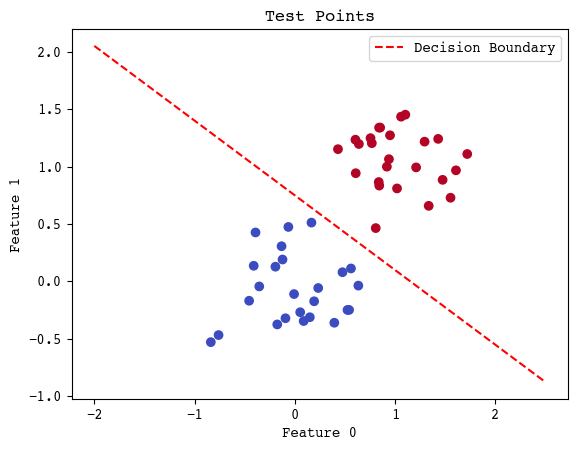

[tensor(0.3256), tensor(0.2145), tensor(0.1533), tensor(0.1152), tensor(0.0909), tensor(0.0832), tensor(0.0864), tensor(0.0829), tensor(0.0862), tensor(0.1157), tensor(0.0863), tensor(0.0697), tensor(0.0955), tensor(0.0742), tensor(0.0568), tensor(0.0519), tensor(0.0419), tensor(0.0470), tensor(0.0419), tensor(0.0419), tensor(0.0381), tensor(0.0343), tensor(0.0493), tensor(0.0342), tensor(0.0412), tensor(0.0312), tensor(0.0341), tensor(0.0274), tensor(0.0257), tensor(0.0276), tensor(0.0258), tensor(0.0277), tensor(0.0259), tensor(0.0278), tensor(0.0260), tensor(0.0211), tensor(0.0339), tensor(0.0233), tensor(0.0183)]
[tensor(0.3256), tensor(0.2145), tensor(0.1533), tensor(0.1152), tensor(0.0909), tensor(0.0832), tensor(0.0864), tensor(0.0829), tensor(0.0862), tensor(0.1157), tensor(0.0863), tensor(0.0697), tensor(0.0955), tensor(0.0742), tensor(0.0568), tensor(0.0519), tensor(0.0419), tensor(0.0470), tensor(0.0419), tensor(0.0419), tensor(0.0381), tensor(0.0343), tensor(0.0493), tensor

Text(0.5, 1.0, 'Model Loss Over Iterations')

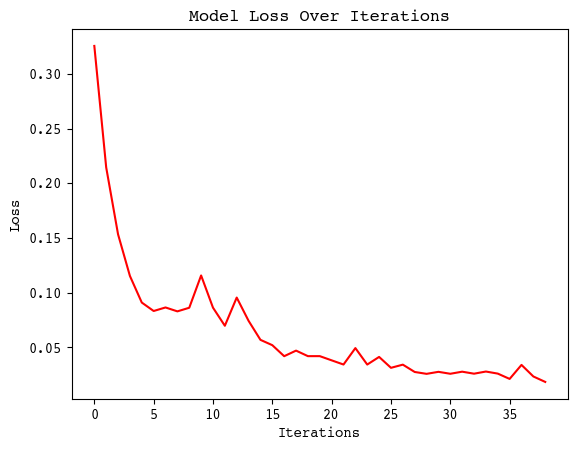

In [40]:
#Test Parameters and data generation
n = 50
p = 2
gamma = .3
X, y = Utility.classification_data(n, gamma, p)
#Adam init and parameters
adam = ADAM()
adam.w = None
batch_size = 10
alpha = .8
beta_1 = .9
beta_2 = .999
tau = 1 / 10**8
epsilon = .01
#Train the model and extract the weights
res = Utility.train_adam(X, y, batch_size, alpha, beta_1, beta_2, tau, epsilon, adam)
w = adam.w
#plotting decision boundary
plt.scatter(X[:,0], X[:, 1], c = y, cmap = "coolwarm")
Utility.draw_line(w, -2, 2.5, plt, color = "red", linestyle = "dashed", label = "Decision Boundary")
plt.legend()
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("Test Points")
plt.show()
#plotting loss over iterations
[num_iters, loss] = res
i = torch.arange(0, num_iters)
plt.plot(i, loss, color = "red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Model Loss Over Iterations")

Using logistic regression, Adam is able to cleanly find the decsion boundary in just under 40 iterations. Turning to the second chart, we see that the emperical loss converges to just south of 0.05. One one clear difference between Adam and previous optimizers is that the loss is not monotonically decreasing (strictly decreasing). This is a directly product of Adam's stochasticity: Some samples may not be good approximation of the gradient as a whole, causing Adam to mistep. Also notice that the relative magnitude of perturbations decreases over runtime duration. This is nice consequence of and Adam's self-annealing error correction term and fact that the size of the gradient is smaller as Adam approaches convergence.  

Next, we'll explore how different batch sizes affects the number of iterations it takes Adam to converge. We'll cut Adam off at 10,000 iterations and take $n = 1000$ and $p = 50$ to better approximate real use cases. We'll keep all the hyperparamters the same except $\alpha$, which we'll set to $\alpha = .5$ to improve precision.

The test itself, $\texttt{adam\_batch\_test}$ runs Adam on each gamma values with each batch size. For each pair, it records the mean number of iterations to $\epsilon$-convergence after 1000 trials.

In [253]:
#Test Parameters and data generation
MAX_ITERS = 10000
n = 1000
p = 30
#Adam init and parameters
adam = ADAM()
adam.w = None
batch_sizes = [5, 10, 50, 100, 150, 300, 500, 750, 900]
alpha = .5
beta_1 = .9
beta_2 = .999
tau = 1 / 10**8
epsilon = .01
trials = 1000
gamma_vals = [.12, .3, .5, .75]

res = Utility.adam_batch_test(n, p, gamma_vals, batch_sizes, trials, [alpha, beta_1, beta_2, tau, epsilon, adam])

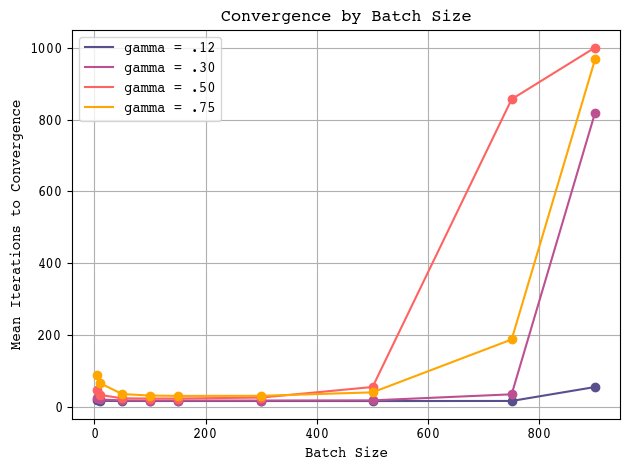

In [254]:
plt.plot(batch_sizes, res[0], 'o', color = "#58508d")
plt.plot(batch_sizes, res[0], color = "#58508d", label = "gamma = .12") # #58508d #bc5090 #ff6361 #ffa600

plt.plot(batch_sizes, res[1], 'o', color = "#bc5090")
plt.plot(batch_sizes, res[1], color = "#bc5090", label = "gamma = .30")
plt.plot(batch_sizes, res[2], 'o', color = "#ff6361")
plt.plot(batch_sizes, res[2], color = "#ff6361", label = "gamma = .50")
plt.plot(batch_sizes, res[3], 'o', color = "#ffa600")
plt.plot(batch_sizes, res[3], color = "#ffa600", label = "gamma = .75") 
plt.xlabel("Batch Size")
plt.ylabel("Mean Iterations to Convergence")
plt.title("Convergence by Batch Size")
plt.tight_layout()
plt.grid(True)
plt.legend()


Here, the different curves correspond to level of noise in the data. Unsurpisingly, increasing the noise also increases the number of iterations to convergence accross all batch sizes. The curves are also U-tailed, with extreme batch size taking more iterations to converge. This makese sense, since fewer points can make it harder to approximate the gradient, whereas too many points leads to higher variances and thereby steps which are too small. The latter has a mutch more dramatic effect on convergence . Interestingly, the region middle region of the graph is quite wide. This suggests that one should err on the side of small to medium batch sizes with Adam, but there are many "correct" choices. This analysis agrees with best practice, which reccomends using the largest batch size which can fit in main memory.

Next, we'll examine Adam's performance when compared to Logistic Regression with Momentum along with its stochastic counterpart. For convenience let's call it Stochastic Descent.


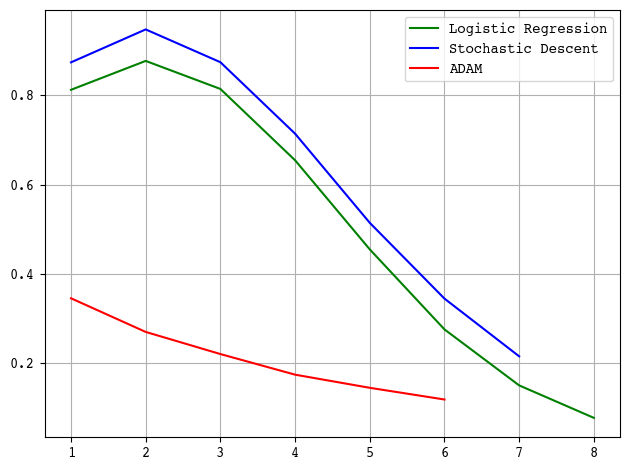

In [399]:
#Initialize Models
logistic = LogisticRegression()
stochastic = StochasticDescent()
adam = ADAM()
#Define Testing Parameters and Generate Data
n = 1000
p = 5
gamma = .25
epsilon = .1
X, y = Utility.classification_data(n, gamma, p)
#logistic parameters
alpha_L = .8
beta_L = .9
#Stochastic Parameters
alpha_S = .8
beta_S = .9
#Adam parameters
adam.w = None
k_batch = 50
alpha = .5
beta_1 = .9
beta_2 = .999
tau = 1 / 10**8

# Training Models
[L_step, L_loss, L_time] = Util.train_logistic(X, y, alpha_L, beta_L, epsilon, logistic)
[S_step, S_loss, S_time] = Utility.train_stochastic(X, y, k_batch, alpha_S, beta_S, epsilon, stochastic)
[A_step, A_loss, A_time] = Utility.train_adam(X, y, k_batch, alpha, beta_1, beta_2, tau, epsilon, adam)
#Plotting
plt.plot(torch.arange(1, L_step + 1), L_loss, label = "Logistic Regression", color = "green")
plt.plot(torch.arange(1, S_step + 1), S_loss, label = "Stochastic Descent", color = "blue")
plt.plot(torch.arange(1, A_step + 1), A_loss, label = "ADAM", color = "red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over Iterations")
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()

Logistic Regression and Stochastic Descent have similar loss curves, with slightly higher loss over time from the stochastic algorithm. We see that Adam is able to converge in about two iterations quicker with less per-iteration loss than the other methods. The peaks are reflective of the momentum term. Interestingly, Adam's step bound seemed to be able to counteract this, leading to smoother convergence.

While this experiment gave us a peak into the mechanics of these algorithms, to assess the performance of random algorithms on random data, we again need to look at averages over many trials. We'll test the performance of these three algorithms on linearly-seperable data, noisy linearly-seperable data, and non-linear data. For each, we'll assess average convergence by iteration count and run time, along with model accuracy. First, we'll start with the non-noisy linearly seperable data. We'll take $\gamma = .25$, $n = 1000$, $p = 50$, and run each algorithm on 1000 different data sets. 

In [ ]:
#Initialize Models
logistic = LogisticRegression()
stochastic = StochasticDescent()
adam = ADAM()
#Define Testing Parameters and Generate Data
n = 1000
p = 50
gamma = .25
epsilon = .05
trials = 1000
#logistic parameters
alpha_L = .8
beta_L = .9
#Stochastic Parameters
alpha_S = .8
beta_S = .9
#Adam parameters
adam.w = None
k_batch = 25
alpha = .5
beta_1 = .9
beta_2 = .999
tau = 1 / 10**8
# Test
L_iters, L_times, L_accuracies = [], [], []
S_iters, S_times, S_accuracies = [], [], []
A_iters, A_times, A_accuracies = [], [], [] 

s = 0

while s < trials:
    X, y = Utility.classification_data(n, gamma, p)
    [L_step, L_loss, L_time] = Util.train_logistic(X, y, alpha_L, beta_L, epsilon, logistic)
    [S_step, S_loss, S_time] = Utility.train_stochastic(X, y, k_batch, alpha_S, beta_S, epsilon, stochastic)
    [A_step, A_loss, A_time] = Utility.train_adam(X, y, k_batch, alpha, beta_1, beta_2, tau, epsilon, adam)
    if not ((math.isnan(logistic.loss(X, y))) and (math.isnan(stochastic.loss(X, y))) and (math.isnan(adam.loss(X, y)))):
        s += 1
        print(s)
        L_iters.append(L_step)
        L_times.append(L_time)
        L_accuracies.append(Utility.algo_accuracy(X, y, logistic))
        S_iters.append(S_step)
        S_times.append(S_time)
        S_accuracies.append(Utility.algo_accuracy(X, y, stochastic))
        A_iters.append(A_step)
        A_times.append(A_time)
        A_accuracies.append(Utility.algo_accuracy(X, y, adam))
    logistic.w = None
    logistic.w_prev = None
    logistic.w_next = None
    stochastic.w = None
    stochastic.w_prev = None
    stochastic.w_next = None
    stochastic.t = 0
    adam.w = None
    adam.w_prev = None
    adam.w_next = None
    adam.m_t = None
    adam.v_t = None
    adam.t = 0
    

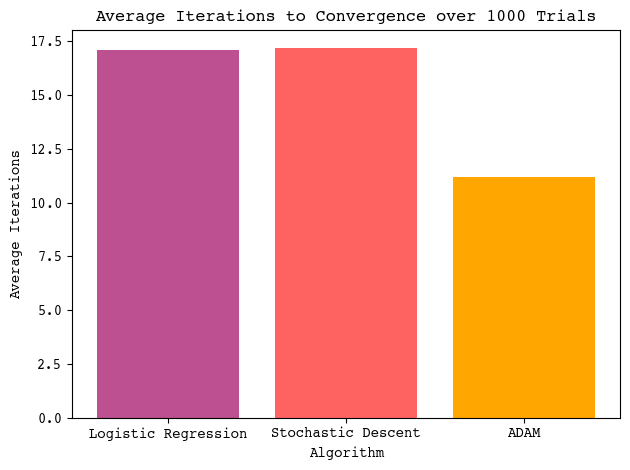

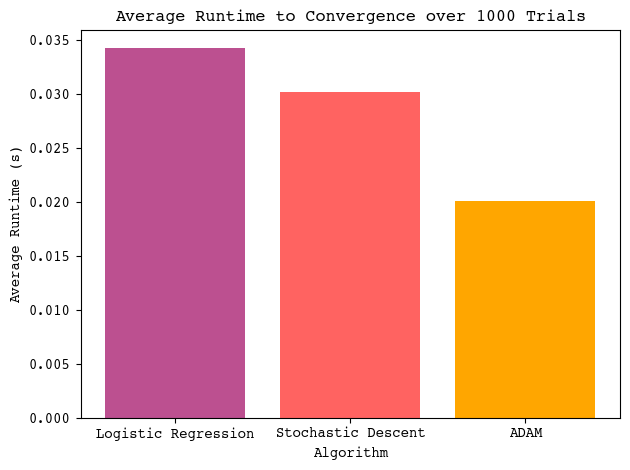

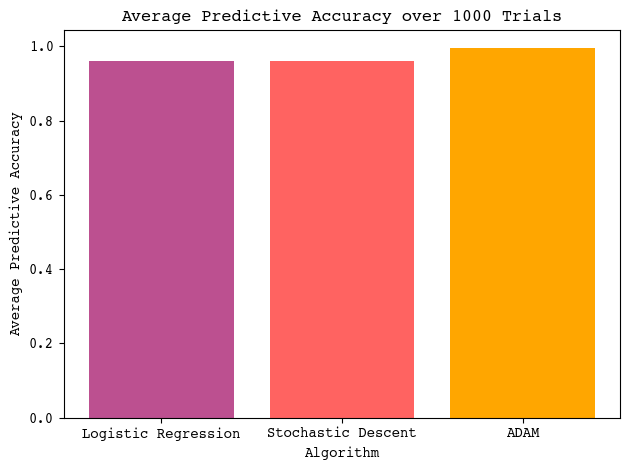

[17.071, 17.167, 11.194]
[0.03419111347198486, 0.030178627967834472, 0.02002998352050781]
[0.960957, 0.9611219999999999, 0.994735]


In [402]:
algorithms = ["Logistic Regression", "Stochastic Descent", "ADAM"]
iterations = [statistics.mean(L_iters), statistics.mean(S_iters), statistics.mean(A_iters)]
times = [statistics.mean(L_times), statistics.mean(S_times), statistics.mean(A_times)]
accuracies = [statistics.mean(L_accuracies), statistics.mean(S_accuracies), statistics.mean(A_accuracies)]

plt.bar(algorithms, iterations, color = ["#bc5090", "#ff6361", "#ffa600"])
plt.xlabel("Algorithm")
plt.ylabel("Average Iterations")
plt.title("Average Iterations to Convergence over 1000 Trials")
plt.tight_layout()
plt.show()

plt.bar(algorithms, times, color = ["#bc5090", "#ff6361", "#ffa600"])
plt.xlabel("Algorithm")
plt.ylabel("Average Runtime (s)")
plt.title("Average Runtime to Convergence over 1000 Trials")
plt.tight_layout()
plt.show()

plt.bar(algorithms, accuracies, color = ["#bc5090", "#ff6361", "#ffa600"])
plt.xlabel("Algorithm")
plt.ylabel("Average Predictive Accuracy")
plt.title("Average Predictive Accuracy over 1000 Trials")
plt.tight_layout()
plt.show()

print(iterations)
print(times)
print(accuracies)

Logistic Regression and Stochastic Descent took on average 17 iterations to converge and ran for about 0.03 seconds. The Stochastic Descent algorithm ran 0.004 seconds quicker, indicating that the batch sampling increased speed of computation. Adam beat both methods, taking on average 11 iterations to converge in 0.02 seconds. Adam also yielded higher predictive accuracy, labeling 99.4% of training observations correctly compared to 96.1% and 96.11% of Logistic Regression and Stochastic Descent respectively.

We'll run the exact same test on noisy data ($\gamma = .75$):

In [ ]:
#Initialize Models
logistic = LogisticRegression()
stochastic = StochasticDescent()
adam = ADAM()
#Define Testing Parameters and Generate Data
n = 1000
p = 50
gamma = .75
epsilon = .05
trials = 1000
#logistic parameters
alpha_L = .8
beta_L = .9
#Stochastic Parameters
alpha_S = .8
beta_S = .9
#Adam parameters
adam.w = None
k_batch = 25
alpha = .5
beta_1 = .9
beta_2 = .999
tau = 1 / 10**8
# Test
L_iters, L_times, L_accuracies = [], [], []
S_iters, S_times, S_accuracies = [], [], []
A_iters, A_times, A_accuracies = [], [], [] 

s = 0

while s < trials:
    X, y = Utility.classification_data(n, gamma, p)
    [L_step, L_loss, L_time] = Util.train_logistic(X, y, alpha_L, beta_L, epsilon, logistic)
    [S_step, S_loss, S_time] = Utility.train_stochastic(X, y, k_batch, alpha_S, beta_S, epsilon, stochastic)
    [A_step, A_loss, A_time] = Utility.train_adam(X, y, k_batch, alpha, beta_1, beta_2, tau, epsilon, adam)
    if not ((math.isnan(logistic.loss(X, y))) and (math.isnan(stochastic.loss(X, y))) and (math.isnan(adam.loss(X, y)))):
        s += 1
        print(s)
        L_iters.append(L_step)
        L_times.append(L_time)
        L_accuracies.append(Utility.algo_accuracy(X, y, logistic))
        S_iters.append(S_step)
        S_times.append(S_time)
        S_accuracies.append(Utility.algo_accuracy(X, y, stochastic))
        A_iters.append(A_step)
        A_times.append(A_time)
        A_accuracies.append(Utility.algo_accuracy(X, y, adam))
    logistic.w = None
    logistic.w_prev = None
    logistic.w_next = None
    stochastic.w = None
    stochastic.w_prev = None
    stochastic.w_next = None
    stochastic.t = 0
    adam.w = None
    adam.w_prev = None
    adam.w_next = None
    adam.m_t = None
    adam.v_t = None
    adam.t = 0
    

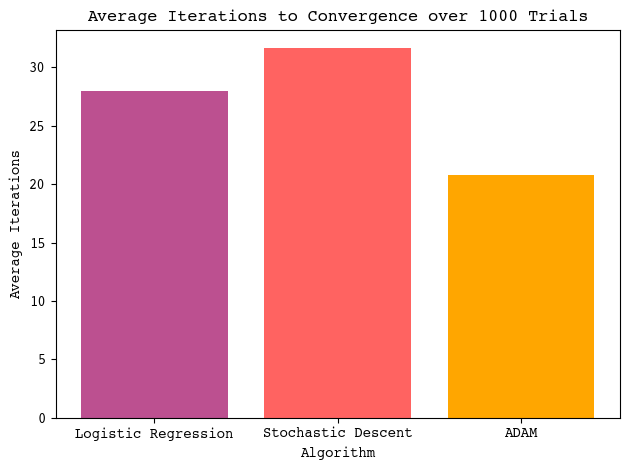

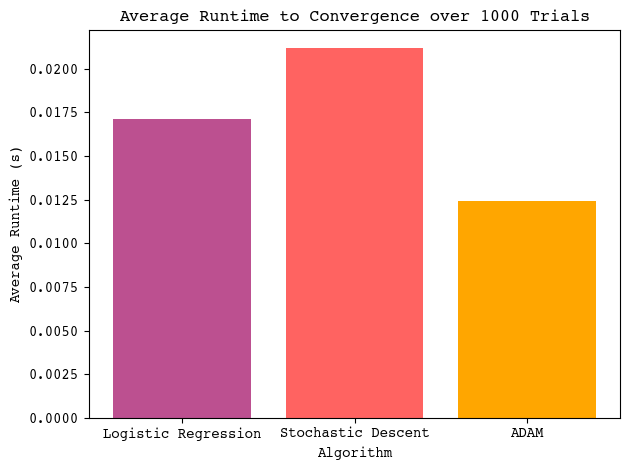

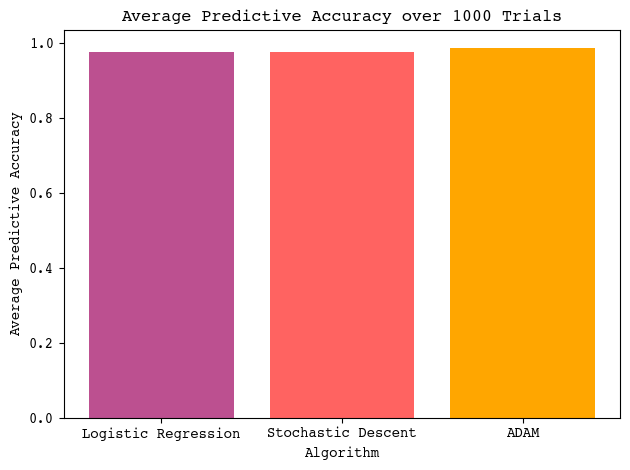

[27.996, 31.635, 20.81]
[0.017142401218414306, 0.02117722225189209, 0.012424294471740722]
[0.9768209999999999, 0.976915, 0.986432]


In [415]:
algorithms = ["Logistic Regression", "Stochastic Descent", "ADAM"]
iterations = [statistics.mean(L_iters), statistics.mean(S_iters), statistics.mean(A_iters)]
times = [statistics.mean(L_times), statistics.mean(S_times), statistics.mean(A_times)]
accuracies = [statistics.mean(L_accuracies), statistics.mean(S_accuracies), statistics.mean(A_accuracies)]

plt.bar(algorithms, iterations, color = ["#bc5090", "#ff6361", "#ffa600"])
plt.xlabel("Algorithm")
plt.ylabel("Average Iterations")
plt.title("Average Iterations to Convergence over 1000 Trials")
plt.tight_layout()
plt.show()

plt.bar(algorithms, times, color = ["#bc5090", "#ff6361", "#ffa600"])
plt.xlabel("Algorithm")
plt.ylabel("Average Runtime (s)")
plt.title("Average Runtime to Convergence over 1000 Trials")
plt.tight_layout()
plt.show()

plt.bar(algorithms, accuracies, color = ["#bc5090", "#ff6361", "#ffa600"])
plt.xlabel("Algorithm")
plt.ylabel("Average Predictive Accuracy")
plt.title("Average Predictive Accuracy over 1000 Trials")
plt.tight_layout()
plt.show()

print(iterations)
print(times)
print(accuracies)

This increases the number iterations to converge and runtime accross all algorithms. Interestingly, Stochastic Descent runs slower than Logistic Regression in terms of iteration count and time; average 28.00 over .017 seconds and 31.64 over .021 seconds respectively. This suggests that the batch sampling method did not pay off on the noisy data. Again, ADAM beats out both methods with an average of 20.81 iterations, and also boasts 98.64% accuracy compared to 97.68% of Logistic Regression and 97.69 of Stochastic Descent. 

Next, we'll see how the algorithms perform when the data is non-linearly seperable. The data has shape

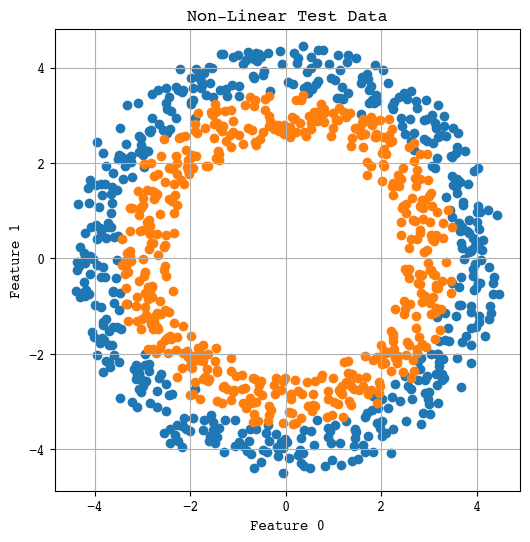

In [406]:
#Input Parameters
n = 500
gamma = .5
p = 2
r1 = 4
r2 = 3
#Non Linear Data
p1 = Circle.generate_points(r1, n, gamma)
p2 = Circle.generate_points(r2, n, gamma)
X = torch.cat((p1, p2), dim = 0)
col = 1.0 * torch.ones(2 * n, 1)
X = torch.cat((X, col), dim = 1)
y1 = 1.0 * torch.zeros(1, n)
y2 = 1.0 * torch.ones(1, n)
y_circ = torch.cat((y1, y2), dim = 1)[0, :]
X_circ = X.float()
#Plotting Non-Linear Data
fig = Circle.plot_points([p1, p2])
plt.show()

We'll run our tests in the same way as above:

In [ ]:
#Initialize Models
logistic = LogisticRegression()
stochastic = StochasticDescent()
adam = ADAM()
#Define Testing Parameters and Generate Data
n = 500
p = 2
gamma = .5
epsilon = .05
trials = 1000
#logistic parameters
alpha_L = .8
beta_L = .9
#Stochastic Parameters
alpha_S = .8
beta_S = .9
#Adam parameters
adam.w = None
k_batch = 25
alpha = .5
beta_1 = .9
beta_2 = .999
tau = 1 / 10**8
# Test
L_iters, L_times, L_accuracies = [], [], []
S_iters, S_times, S_accuracies = [], [], []
A_iters, A_times, A_accuracies = [], [], [] 

s = 0

while s < trials:
    p1 = Circle.generate_points(r1, n, gamma)
    p2 = Circle.generate_points(r2, n, gamma)
    X = torch.cat((p1, p2), dim = 0)
    col = 1.0 * torch.ones(2 * n, 1)
    X = torch.cat((X, col), dim = 1)
    y1 = 1.0 * torch.zeros(1, n)
    y2 = 1.0 * torch.ones(1, n)
    y_circ = torch.cat((y1, y2), dim = 1)[0, :]
    X_circ = X.float()
    [L_step, L_loss, L_time] = Util.train_logistic(X_circ, y_circ, alpha_L, beta_L, epsilon, logistic)
    [S_step, S_loss, S_time] = Utility.train_stochastic(X_circ, y_circ, k_batch, alpha_S, beta_S, epsilon, stochastic)
    [A_step, A_loss, A_time] = Utility.train_adam(X_circ, y_circ, k_batch, alpha, beta_1, beta_2, tau, epsilon, adam)
    if not ((math.isnan(logistic.loss(X_circ, y_circ))) and (math.isnan(stochastic.loss(X_circ, y_circ))) and (math.isnan(adam.loss(X_circ, y_circ)))):
        s += 1
        print(s)
        L_iters.append(L_step)
        L_times.append(L_time)
        L_accuracies.append(Utility.algo_accuracy(X_circ, y_circ, logistic))
        S_iters.append(S_step)
        S_times.append(S_time)
        S_accuracies.append(Utility.algo_accuracy(X_circ, y, stochastic))
        A_iters.append(A_step)
        A_times.append(A_time)
        A_accuracies.append(Utility.algo_accuracy(X_circ, y_circ, adam))
    logistic.w = None
    logistic.w_prev = None
    logistic.w_next = None
    stochastic.w = None
    stochastic.w_prev = None
    stochastic.w_next = None
    stochastic.t = 0
    adam.w = None
    adam.w_prev = None
    adam.w_next = None
    adam.m_t = None
    adam.v_t = None
    adam.t = 0
    

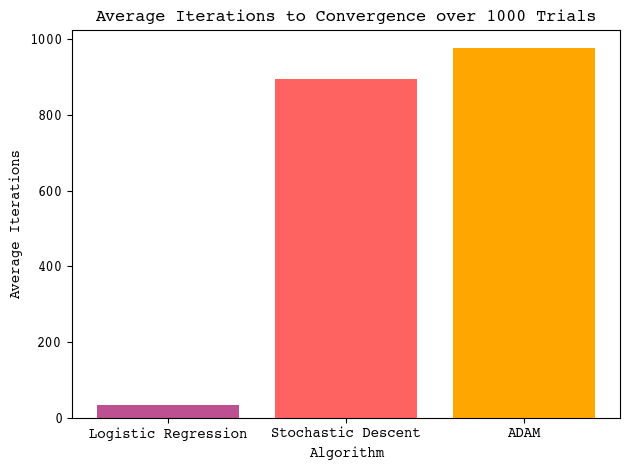

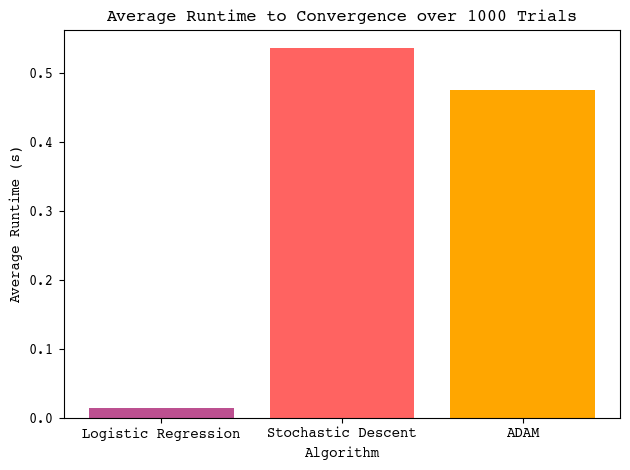

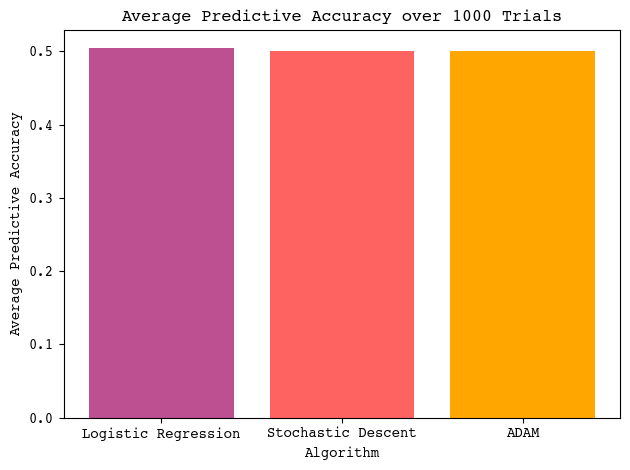

[32.873, 894.254, 976.287]
[0.014596573829650879, 0.5360904953479767, 0.4758875901699066]
[0.503959, 0.500758, 0.49998]


In [413]:
algorithms = ["Logistic Regression", "Stochastic Descent", "ADAM"]
iterations = [statistics.mean(L_iters), statistics.mean(S_iters), statistics.mean(A_iters)]
times = [statistics.mean(L_times), statistics.mean(S_times), statistics.mean(A_times)]
accuracies = [statistics.mean(L_accuracies), statistics.mean(S_accuracies), statistics.mean(A_accuracies)]

plt.bar(algorithms, iterations, color = ["#bc5090", "#ff6361", "#ffa600"])
plt.xlabel("Algorithm")
plt.ylabel("Average Iterations")
plt.title("Average Iterations to Convergence over 1000 Trials")
plt.tight_layout()
plt.show()

plt.bar(algorithms, times, color = ["#bc5090", "#ff6361", "#ffa600"])
plt.xlabel("Algorithm")
plt.ylabel("Average Runtime (s)")
plt.title("Average Runtime to Convergence over 1000 Trials")
plt.tight_layout()
plt.show()

plt.bar(algorithms, accuracies, color = ["#bc5090", "#ff6361", "#ffa600"])
plt.xlabel("Algorithm")
plt.ylabel("Average Predictive Accuracy")
plt.title("Average Predictive Accuracy over 1000 Trials")
plt.tight_layout()
plt.show()

print(iterations)
print(times)
print(accuracies)

Unsurprisingly, accuracy dropped lower accross all algorithms to around 50%. Both stochastic methods converged in around 900 iterations running for about half a second. Logistic Regression was the clear winer, taking just 32 iterations to converge in just 0.01 seconds. This indicates that without feature mapping, linear stochastic algorithms should not be applied to non-linear data sets, as the sampling approach fails to provide a holistic picture of the loss function.

# Test Cases

Next, we will examine ADAM's performance vs a Stochastic instance of gradient descent on two real data sets.

## Lucky Number 13

First, we will examine scikit-learn's digits data set. The data set contains $8 \times 8$ pixel images of the handwritten digits $0 - 9$, and is a commonly used benchmark for machine learning algorithms. We transform the data set into a torch tensor of floats. We can get a feel for the data by printing out some of the images as follows:

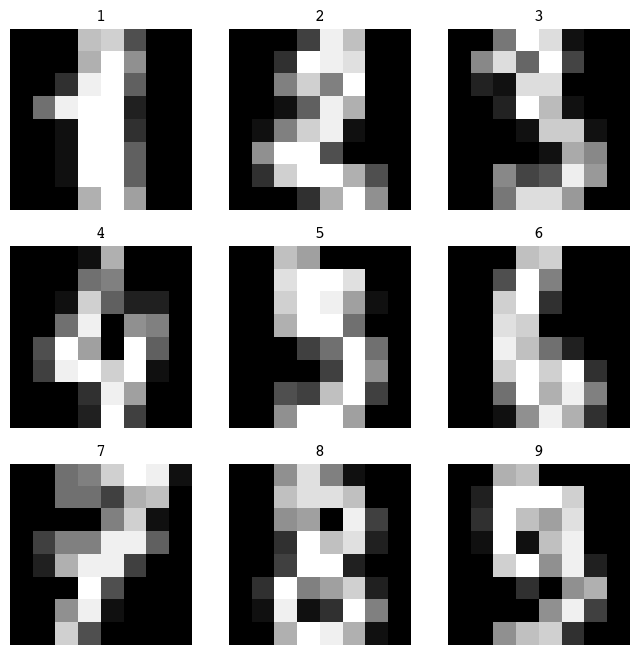

In [17]:
data = load_digits() # load the digits data from sckikit-learn
digits = pd.DataFrame(data = data.data, columns = [f"pixel_{i}" for i in range(data.data.shape[1])]) # "flatten" the data such that each row corresponds to a digit, and columns are the pixels
digits["target"] = data.target # asign correspond integer label

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (8, 8))

for digit in range(1, 10):

    digit_data = digits[digits["target"] == digit].head(1)
    digit_image = digit_data.iloc[0, :-1].values.reshape(8, 8)
    ax = axes[(digit - 1) // 3, (digit - 1) % 3]
    ax.imshow(digit_image, cmap = "grey")
    ax.set_title(f"{digit}")
    ax.axis("off")

plt.show()

Notice that since the instances of Logistic Regression that we are using only support two label classification, we must choose two digits and assign a binary label to them. Here, we'll take $1$ and $3$:

In [ ]:
# grab digits
two_digits = digits[digits["target"].isin([1, 3])] # only look at digits 1,3
two_digits["label"] = (two_digits["target"] == 1).astype(int) # assign binary lable

We also need to seperate the labels from the data. We do this as follows:

In [33]:
# seperate labels from data
X = torch.tensor(two_digits.drop(columns = ["label", "target"]).values, dtype = float).float() # convert to torch tensor
y = torch.tensor(two_digits["label"].values, dtype = float).float() # convert to torch tensor

We are now ready to test the performance of the algorithms. Similar to our other tests, we'll look at the number of epochs (iterations) to convergence, the time in seconds it takes the algorithms to converge, as well as the accuracy of each algorithm on the training set. 

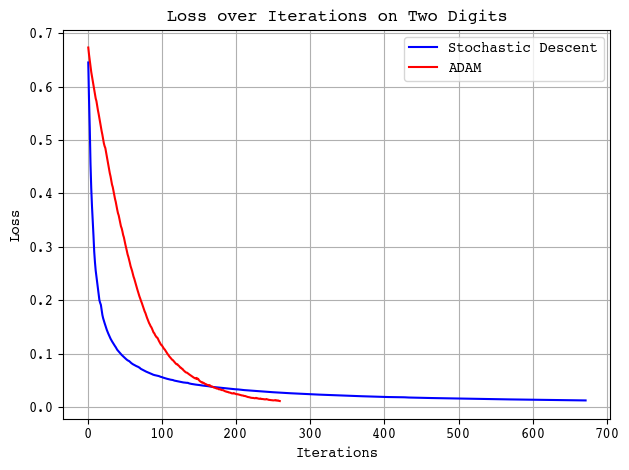

Stochastic Descent converged in 671 epochs.
ADAM converged in 259epochs.


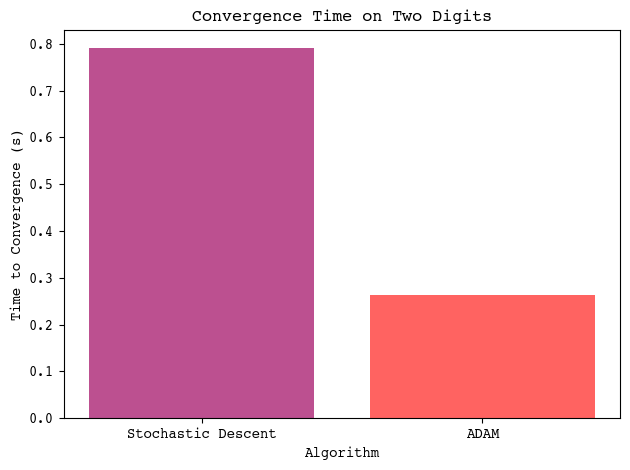

Stochastic Descent took 0.790539026260376 seconds to converge.
ADAM took 0.26377224922180176 seconds to converge.


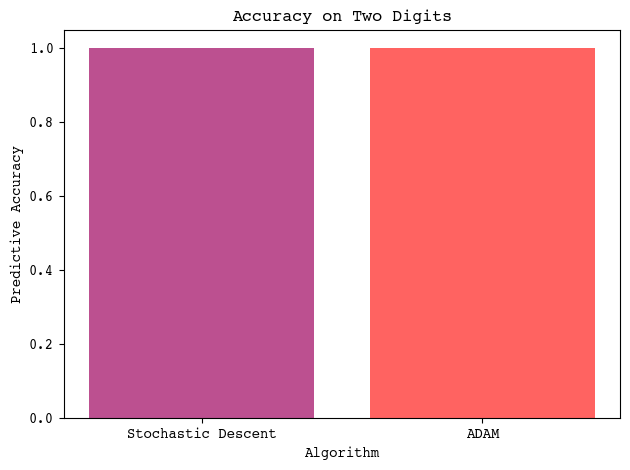

Stochastic Descent had an accuracy of 100.0%.
ADAM had an accuracy of 100.0%.


In [34]:
# epsilon tolerance
epsilon = .1
#Initialize Models
stochastic = StochasticDescent()
adam = ADAM()
#Stochastic Parameters
alpha_S = .8
beta_S = .5
#Adam parameters
adam.w = None
k_batch = 50
alpha = .5
beta_1 = .9
beta_2 = .999
tau = 1 / 10**8

# Training Models
[S_step, S_loss, S_time] = Utility.train_stochastic(X, y, k_batch, alpha_S, beta_S, epsilon, stochastic)
[A_step, A_loss, A_time] = Utility.train_adam(X, y, k_batch, alpha, beta_1, beta_2, tau, epsilon, adam)
#Plotting
algorithms = ["Stochastic Descent", "ADAM"]
# plotting loss over epochs
plt.plot(torch.arange(1, S_step + 1), S_loss, label = "Stochastic Descent", color = "blue")
plt.plot(torch.arange(1, A_step + 1), A_loss, label = "ADAM", color = "red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over Iterations on Two Digits")
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()
# printing results
print("Stochastic Descent converged in " + str(S_step) + " epochs.")
print("ADAM converged in " + str(A_step) + " epochs.")
# plotting times
plt.bar(algorithms, [S_time, A_time], color = ["#bc5090", "#ff6361"])
plt.xlabel("Algorithm")
plt.ylabel("Time to Convergence (s)")
plt.title("Convergence Time on Two Digits")
plt.tight_layout()
plt.show()
# printing results
print("Stochastic Descent took " + str(S_time) + " seconds to converge.")
print("ADAM took " + str(A_time) + " seconds to converge.")
[S_acc, A_acc] = [Utility.algo_accuracy(X, y, stochastic), Utility.algo_accuracy(X, y, adam)]
# plotting accuracies
plt.bar(algorithms, [S_acc, A_acc], color = ["#bc5090", "#ff6361"])
plt.xlabel("Algorithm")
plt.ylabel("Predictive Accuracy")
plt.title("Accuracy on Two Digits")
plt.tight_layout()
plt.show()
# printing results
print("Stochastic Descent had an accuracy of " + str(S_acc * 100) + "%.")
print("ADAM had an accuracy of " + str(A_acc * 100) + "%.")

Both models achieved 100 % accuracy. ADAM was significantly quicker, converging in about .26 seconds compared to Stochastic Descent's time of .79. Interestingly, Stochastic Descent descended quicker than ADAM, but struggled to converge to a small enough gradient. This phenomenon is likely a product of ADAM's self-annealing error correction term, which decreases the magnitude of the step as the number of iterations increase. 

# Palmer Penguins!

Next, we'll test the models on a familar dataset. The Palmer Penguins! 

![Dat boi.](media/penguin.jpg)

We'll apply a similar procedure to the digits dataset: Load the data, convert features and labels to torch tensors, and choose two penguins to classify.

In [24]:
target_features = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)"]
penguins = Penguins.loadTrainingData()
[penguins, labels] = Penguins.prepareData(penguins)
two_penguins = penguins[penguins["Species"].isin([0, 1])]
y = torch.tensor(two_penguins["Species"].values, dtype = float).float()
X = torch.tensor(two_penguins[target_features].values, dtype = float).float()

We'll run identical test, slightly tuning the testing parameters to fit the data.  

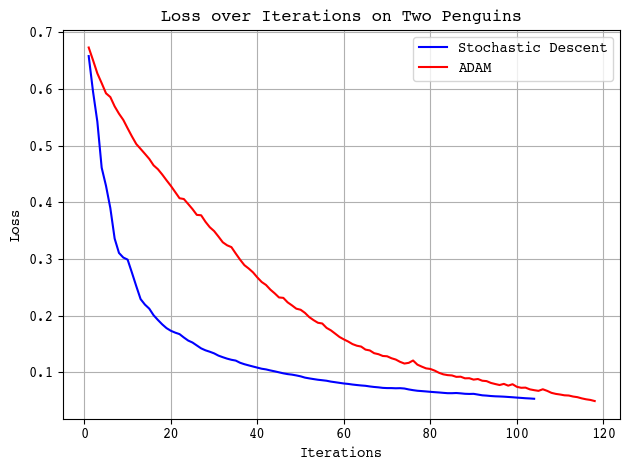

Stochastic Descent converged in 104 epochs.
ADAM converged in 118epochs.


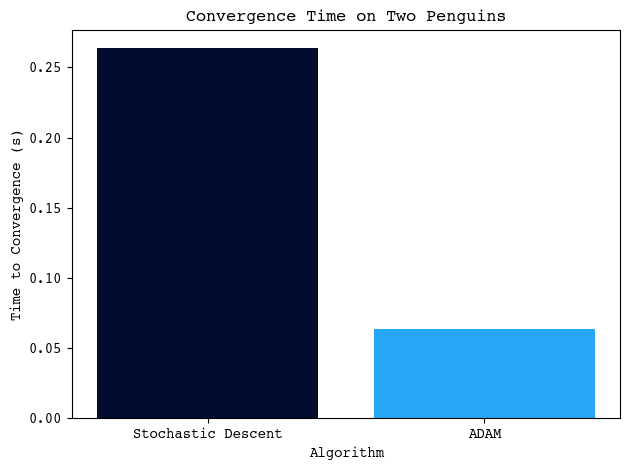

Stochastic Descent took 0.26360511779785156 seconds to converge.
ADAM took 0.06348228454589844 seconds to converge.


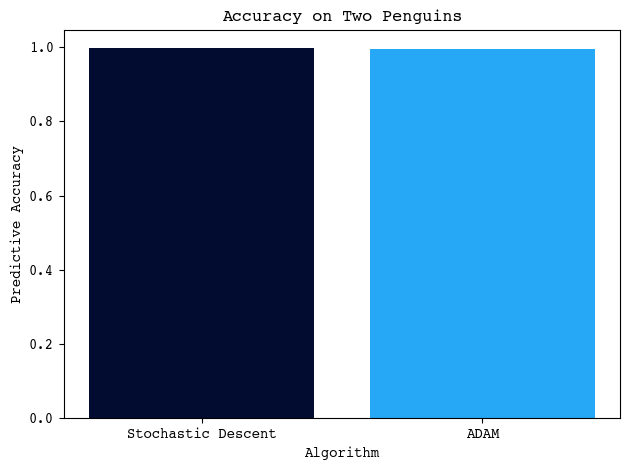

Stochastic Descent had an accuracy of 99.72602739726028%.
ADAM had an accuracy of 99.45205479452055%.


In [35]:
# epsilon tolerance
epsilon = .5
#Initialize Models
stochastic = StochasticDescent()
adam = ADAM()
#Stochastic Parameters
alpha_S = .8
beta_S = .5
#Adam parameters
adam.w = None
k_batch = 25
alpha = .9
beta_1 = .9
beta_2 = .999
tau = 1 / 10**8

# Training Models
[S_step, S_loss, S_time] = Utility.train_stochastic(X, y, k_batch, alpha_S, beta_S, epsilon, stochastic)
[A_step, A_loss, A_time] = Utility.train_adam(X, y, k_batch, alpha, beta_1, beta_2, tau, epsilon, adam)
#Plotting
algorithms = ["Stochastic Descent", "ADAM"]
# plotting loss over epochs
plt.plot(torch.arange(1, S_step + 1), S_loss, label = "Stochastic Descent", color = "blue")
plt.plot(torch.arange(1, A_step + 1), A_loss, label = "ADAM", color = "red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over Iterations on Two Penguins")
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()
# printing results
print("Stochastic Descent converged in " + str(S_step) + " epochs.")
print("ADAM converged in " + str(A_step) + "epochs.")
# plotting times
plt.bar(algorithms, [S_time, A_time], color = ["#010c30", "#27a8f7"])
plt.xlabel("Algorithm")
plt.ylabel("Time to Convergence (s)")
plt.title("Convergence Time on Two Penguins")
plt.tight_layout()
plt.show()
# printing results
print("Stochastic Descent took " + str(S_time) + " seconds to converge.")
print("ADAM took " + str(A_time) + " seconds to converge.")
[S_acc, A_acc] = [Utility.algo_accuracy(X, y, stochastic), Utility.algo_accuracy(X, y, adam)]
# plotting accuracies
plt.bar(algorithms, [S_acc, A_acc], color = ["#010c30", "#27a8f7"])
plt.xlabel("Algorithm")
plt.ylabel("Predictive Accuracy")
plt.title("Accuracy on Two Penguins")
plt.tight_layout()
plt.show()
# printing results
print("Stochastic Descent had an accuracy of " + str(S_acc * 100) + "%.")
print("ADAM had an accuracy of " + str(A_acc * 100) + "%.")



Again, both algorithms yield similar accuracies. Adam took 14 more epochs to converge when compared to Stochastic Descent (118 vs 104) but did so faster (0.063 s vs 0.26). Similar to the digits data set, ADAM had a smaller loss slope compared to Stochastastic Descent, despite the higher learning rate ($\alpha = .9$ and $\alpha = .8$ respectively). In both cases, the analysis suggests that while ADAM may occasional take more epochs to converge, it does in a more computationally effecient manner.

# Conclusion

Today, we explored the ADAM algorithm for gradient descent. We investigated the notion of sampling-based descent methods, and derived some of the error correction terms used in the algorithm. We then tested the algorithm in choice experimental cases along with some real datasets. There are three main takeaways. First, aside from extreme values, batch size does not appear to have a significant affect on ADAM's iteration to convergence. This suggests that the hardware should determine the size of the mini batch as oppose to the data itself. Second, is that ADAM still yields significant performance benefits on noisy data. Third, ADAM is fast. Accross all tests, ADAM outperformed it's countparts in terms of speed. It is then no suprise the ADAM is when of the choice algorithms for modern machine learning tasks.